<a href="https://colab.research.google.com/github/William1202-fox/tsla-backtrader-project/blob/main/my_strategy_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.1 安裝必要套件**

In [2]:
#backtrader 回測框架
#yfincance 下載美股日線
#pandas、matplotlib 處理、畫資料
!pip install -q backtrader yfinance pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.1 MB/s eta 0:00:00


**1.2 下載歷史股價資料**

In [3]:
import yfinance as yf
data = yf.download("TSLA", start = "2010-01-01", end = "2025-05-22", group_by = "column")
print(data.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-05-15  342.820007  346.140015  334.720001  340.339996   97882600
2025-05-16  349.980011  351.619995  342.329987  346.239990   95895700
2025-05-19  342.089996  343.000000  333.369995  336.299988   88869900
2025-05-20  343.820007  354.989990  341.630005  347.869995  131715500
2025-05-21  334.619995  347.350006  332.200012  344.429993  102354800


**1.3 檢查欄位格式**

In [4]:
print(data.columns)

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


**2.1 把 MultiIndex 攤平成單層欄名**

In [5]:
data.columns = data.columns.get_level_values(0)
print(data.head())
print(data.columns)

Price          Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


**2.2 存成csv檔**

In [7]:
data.to_csv("tsla.csv")

**2.3 檢查缺值**

In [8]:
print(data.isna().sum())

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


**3.1 定義布林通道策略**

In [9]:
import backtrader as bt
import datetime as dt

class BollingerReentry(bt.Strategy):
  params = dict(
      period = 20,        #布林通道週期
      devfactor = 2.0,    #標準差倍數
      cash_pct = 0.30,    #每次投入現金比例
      exit_date = dt.date(2025, 5, 21)    #最後平倉日
  )

  def __init__(self):
    #建立布林通道指標（上、中、下軸）
    self.boll = bt.indicators.BollingerBands(
        self.data.close,
        period = self.p.period,
        devfactor = self.p.devfactor
    )

  def next(self):
      #在遇到收盤價碰到下軸，用現金30%買進
      if self.data.close[0] <= self.boll.bot[0]:
          cash_avail = self.broker.getcash()
          buy_cash = cash_avail * self.p.cash_pct
          size = int(buy_cash / self.data.close[0])
          if size > 0:
            self.buy(size = size)

      if self.data.datetime.date(0) >= self.p.exit_date and self.position:
        self.close()

**4.1 回測分析器**
*   Annualized return
*   Sharpe ratio
*   Max drawdown
*   equity curve

Final equity: 249,735,629.14
Annualized return : 44.94%
Sharpe ratio      : 0.06
Max drawdown      : 73.6%


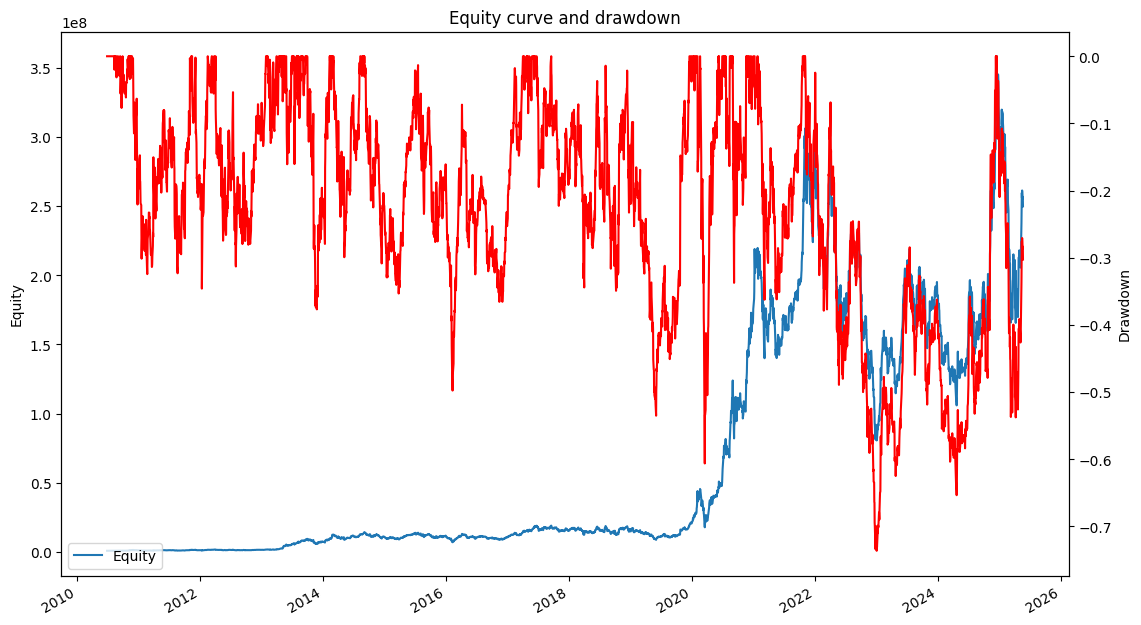

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cerebro = bt.Cerebro()
feed = bt.feeds.PandasData(dataname = data)
cerebro.adddata(feed)
cerebro.addstrategy(BollingerReentry)
cerebro.broker.setcash(1_000_000)
cerebro.broker.setcommission(commission = 0.001) #假設0.1%手續費

#日報酬率、夏普、最大回撤
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days, _name='timeret')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, riskfreerate=0.0, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')

result = cerebro.run()[0]
final_value = cerebro.broker.getvalue()
print(f"Final equity: {final_value:,.2f}")

daily_ret = result.analyzers.timeret.get_analysis()     # dict {date: ret}
rets = pd.Series(daily_ret).sort_index()
ann_return = (final_value / 1_000_000) ** (252 / len(rets)) - 1
sharpe = result.analyzers.sharpe.get_analysis()['sharperatio']
max_dd = result.analyzers.dd.get_analysis()['max']['drawdown'] / 100

print(f"Annualized return : {ann_return:.2%}")
print(f"Sharpe ratio      : {sharpe:.2f}")
print(f"Max drawdown      : {max_dd:.1%}")

equity = (1 + rets).cumprod() * 1_000_000
drawdown = equity / equity.cummax() - 1

fig, ax = plt.subplots(figsize=(13,8))
equity.plot(ax=ax, label='Equity')
drawdown.plot(ax=ax, secondary_y=True, label='Drawdown', color='red')
ax.set_title('Equity curve and drawdown')
ax.set_ylabel('Equity')
ax.right_ax.set_ylabel('Drawdown')
ax.legend(loc='lower left')
plt.show()